Cell 1 — Imports & Configuration

In [1]:
# Cell 1: Setup and Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr
import os

# Paths
PROJECT_ROOT = Path(r"D:\Portfolio Optimzation project")
DATA_DIR = PROJECT_ROOT / "data"
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
RESULTS_DIR = PROJECT_ROOT / "results" / "diagnostics"

os.makedirs(RESULTS_DIR, exist_ok=True)

# Files
PRICE_FILE = DATA_DIR / "price_data.csv"          # date, ticker, close_price
ALPHA_FILE = ARTIFACTS_DIR / "alpha_predictions.csv"

# Settings
REB_FREQ = "M"          # monthly alpha frequency
PRED_HORIZON = 21       # 21 trading days = 1 month
ROLL_WINDOW = 6         # rolling mean of 6 months


Cell 2 — Load and Prepare Data

In [2]:
# Cell 2: Load and prepare data

# Load alpha predictions
alpha_df = pd.read_csv(ALPHA_FILE, parse_dates=["date"])
alpha_df["date"] = pd.to_datetime(alpha_df["date"]).dt.tz_localize(None)
print(f"Alpha data: {alpha_df.shape[0]} rows, {alpha_df['date'].nunique()} dates")

# Load price data
price_df = pd.read_csv(PRICE_FILE, parse_dates=["date"])
price_df["date"] = pd.to_datetime(price_df["date"]).dt.tz_localize(None)
print(f"Price data: {price_df.shape[0]} rows, {price_df['ticker'].nunique()} tickers")

# Pivot to wide for returns
price_wide = price_df.pivot(index="date", columns="ticker", values="close_price").sort_index()

# Compute daily returns
returns = price_wide.pct_change()

# Compute next-month (21-day) forward returns
fwd_returns = price_wide.shift(-PRED_HORIZON) / price_wide - 1.0
fwd_returns = fwd_returns.stack().rename("realized_return").reset_index()


Alpha data: 44376 rows, 106 dates
Price data: 1063311 rows, 497 tickers


C:\Users\rajya\AppData\Local\Temp\ipykernel_20120\771740478.py:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = price_wide.pct_change()


Cell 3 — Merge Predicted vs Realized Returns

In [3]:
# Cell 3: Merge predicted vs realized returns

# Merge alpha predictions (predicted_return at t) with realized returns (t+1)
merged = alpha_df.merge(fwd_returns, on=["date", "ticker"], how="inner")
print(f"Merged rows: {merged.shape[0]}")

# Drop missing or extreme values
merged = merged.replace([np.inf, -np.inf], np.nan).dropna(subset=["predicted_return", "realized_return"])

# Sort chronologically
merged = merged.sort_values("date").reset_index(drop=True)

print("Date range:", merged["date"].min(), "→", merged["date"].max())
print("Sample rows:")
display(merged.head())


Merged rows: 44376
Date range: 2016-08-31 00:00:00 → 2025-05-30 00:00:00
Sample rows:


,date,ticker,predicted_return,realized_return
0,2016-08-31,3MINDIA_DAILY,0.023100,0.027365
1,2016-08-31,NHPC_DAILY,0.017804,-0.087189
2,2016-08-31,NEULANDLAB_DAILY,0.020199,0.012220
3,2016-08-31,NETWORK18_DAILY,0.017736,0.024784
4,2016-08-31,NESTLEIND_DAILY,0.023866,0.020031


Cell 4 — Compute Information Coefficient (IC)

In [4]:
# Cell 4: Compute IC per date

ic_records = []
for d, g in merged.groupby("date"):
    if g["predicted_return"].nunique() < 5 or g["realized_return"].nunique() < 5:
        continue
    ic, _ = spearmanr(g["predicted_return"], g["realized_return"])
    ic_records.append({"date": d, "IC": ic, "n": len(g)})

ic_df = pd.DataFrame(ic_records).sort_values("date")
ic_df["rolling_mean"] = ic_df["IC"].rolling(ROLL_WINDOW).mean()
ic_df["rolling_std"]  = ic_df["IC"].rolling(ROLL_WINDOW).std()

# Summary metrics
mean_ic = ic_df["IC"].mean()
std_ic  = ic_df["IC"].std()
pos_ic  = (ic_df["IC"] > 0).mean() * 100
print(f"Mean IC: {mean_ic:.4f} | Std: {std_ic:.4f} | Positive: {pos_ic:.1f}%")

# Save IC results
ic_df.to_csv(RESULTS_DIR / "ic_timeseries.csv", index=False)


Mean IC: 0.0047 | Std: 0.1379 | Positive: 45.9%


Cell 5 — Visualize IC Behavior

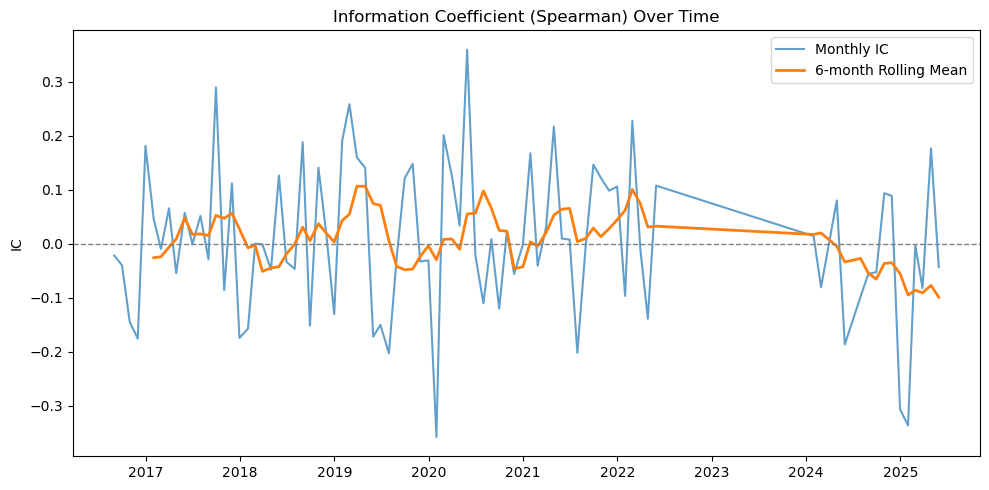

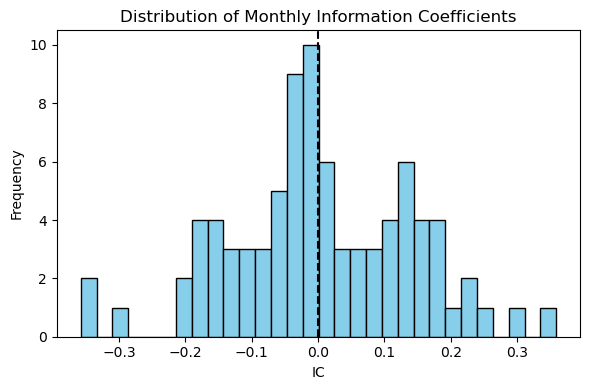

In [5]:
# Cell 5: Visualization

plt.figure(figsize=(10,5))
plt.plot(ic_df["date"], ic_df["IC"], label="Monthly IC", color="tab:blue", alpha=0.7)
plt.plot(ic_df["date"], ic_df["rolling_mean"], label=f"{ROLL_WINDOW}-month Rolling Mean", color="tab:orange", linewidth=2)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Information Coefficient (Spearman) Over Time")
plt.ylabel("IC")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_DIR / "ic_timeseries.png", dpi=200)
plt.show()

# IC histogram
plt.figure(figsize=(6,4))
plt.hist(ic_df["IC"].dropna(), bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Monthly Information Coefficients")
plt.xlabel("IC")
plt.ylabel("Frequency")
plt.axvline(0, color="black", linestyle="--")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "ic_histogram.png", dpi=200)
plt.show()
